# Graded exercise 3: Sampling in high dimension

The aim of the exercices is to test the following:
- Python/Numpy/plotting skills
- Using external sources to find the functions you need
- Theoretical comprehension of the notion of:
    1. sampling with Markov Chain Monte Carlo.
    2. empirical estimators and their error.
    3. high dimensional phenomena.

Each question is given in a markdown cell and should be answered in the cell/cells below (you can add cells if needed). 
The figures must be generated and shown directly in this notebook. 
If a questions demands that you write an answer, use a 'markdown' cell, which can include latex between \\$ symbols. As an example,
\\$\vec{F}=m\vec{a}\\$
gives $\vec{F}=m\vec{a}$.

Remember:
- Add labels for both axes to each plot and a legend whenever you are plotting multiple curves on the same figure, even when not specified in the question.
- Your code (including the plotting of the figures) should run  when restarting the kernel and executing all the cells in sequence from top to bottom. 
- Running all cells should take a reasonable time on noto (<2 min.), with the possible exception of Question 4.20 which should not take more than 5 min., see below.
- All the sources you consult should be explicitly cited, except the numpy and matplotlib official documentation, the lecture notes and the previous exercises. 
    You are encouraged to use external sources, since every function needed in this exercise has not necessarily been seen in the previous exercises.
    You can cite the sources directly in the cells where you used them by adding either a comment in the Markdown text, or a Python comment in the code.
- Working together and citing each other does not mean copy/pasting each other code, text or equations. Please write your own responses to each of the questions, whatever sources you used.

Hint: Recall that using for-loops over elements of a large array is very inefficent. It should be avoided everywhere in the code, i.e. you should instead use numpy array operations over the data samples as much as possible.

### Introduction 

Before starting, let us remind some definitions.
The $d$-dimensional unit cube $H_d$ is the set $H_d = [-1, 1]^d \subset \mathbb{R}^d$, i.e. the centered  cube with side of length 2. 
The $d$-dimensional disk $D_d$ is the set $D_d = \{ x \in \mathbb{R}^d \text{ such that } ||x|| \leq 1\} \subset \mathbb{R}^d$. 
The $d$-dimensional Euclidean norm is defined as 
$$
    ||x||^2 = \sum_{i=1}^d x_i^2 \, .
$$

In this exercise, we will experiment how Markov Chain Monte Carlo (MCMC) methods can drastically improve sampling efficiency in high dimension.
We will consider and compare 2 strategies for sampling i.i.d. points uniformly distributed in the disk:
1) Direct sampling: we sample $n$ i.i.d. points in the cube, and reject all the points that are not in the disk. The remaining samples are i.i.d. in the disk.
2) MCMC: we perform a carefully engineerd random walk for $T$ time steps in the disk, such that all samples are directly i.i.d. in the disk.

We will use the i.i.d. sample that we obtain to compute the average length of a vector uniformly distributed on the disk, i.e. to compute
$$
    \mathbb{E}_{x \sim D_d} [||x||] = \frac{
        \int_{||x|| \leq 1} d^dx \, ||x||
    }{
        \int_{||x|| \leq 1} d^dx 
    }
$$
where the notation $\mathbb{E}_{x \sim D_d} f(x)$ is a shortand for "average of the function $f(x)$ for $x$ uniformly distributed over the set $D_d$". 




In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1: computing the theoretical expectation

The average value we want to compute using direct sampling and MCMC is given by 
$$
    \mathbb{E}_{x \sim D_d} [||x||] = \frac{
        \int_{||x|| \leq 1} d^dx \, ||x||
    }{
        \int_{||x|| \leq 1} d^dx 
    }
$$

In this particular case, we can compute the integral by hand in order to obtain a true value against which we can compare the performance of our algorithms.

**Ex 1.1 (1 pt)** Compute the expectation value defined above. Your computation should fit in one line. 

Hint: use hyperspherical coordinates, and realise that you do not really need to explicitate nor compute the angular part.

**Answer**

We have
$$
    \mathbb{E}_{x \sim D_d} [||x||] = \frac{
        \int_{||x|| \leq 1} d^dx \, ||x||
    }{
        \int_{||x|| \leq 1} d^dx 
    }
    = \frac{
        \int_0^1 dr r^{d-1} \, r \times \text{angular part}
    }{
        \int_0^1 dr r^{d-1} \times \text{angular part}
    }
    = \frac{
        \int_0^1 dr r^{d} 
    }{
        \int_0^1 dr r^{d-1} 
    }
    = \frac{
        d
    }{
        d+1
    }
$$
where the angular part is totally independent on the radial coordinate, and equal in the numerator and denominator, and thus simplifies.

**Ex 1.2 (0.5 pt)** Write a function that computes the theoretical expectation defined above, given the dimension $d$.

In [2]:
def theoretical_avg(d):
    return d/(d+1)

## Exercise 2: direct sampling in high dimension

We start by implementing direct sampling. 

**2.1 (1 pt)**
Write a function that:
- Takes as input the dimension $d$ and the number of samples $n$
- Generates $n$ independent points uniformly distributed in $H_d$
- Discards all points that are not in $D_d$
- Returns the non-discarded points as an array of d-dimensional arrays

Before returning the result, your function should check that the returned array is not empty. If it is, print the string f"No points sampled for d={d} and n={n}" and return `np.array([[0,0]])`.

Print the result of your function for $d=2$ and $n=10$, and for $d=15$ and $n=10$.

In [3]:
def direct_sampling(d, n):
    points = (np.random.uniform(size=(n,d)) * 2) - 1
    norm = np.linalg.norm(points,axis=1)
    res = points[norm<=1]
    if len(res) > 0:
        return res
    else:
        print(f"No points sampled for d={d} and n={n}") 
        return np.array([[0,0]])

print(direct_sampling(2,10))
print(direct_sampling(15,10))

[[-0.25674123 -0.31113044]
 [ 0.44080607 -0.54851798]
 [-0.64282278  0.70064225]
 [-0.35100319 -0.35514219]
 [-0.36192904  0.58413757]
 [ 0.64825342  0.46110929]
 [ 0.45718282  0.75810302]
 [-0.85280536  0.43074514]
 [-0.50453143  0.70327777]]
No points sampled for d=15 and n=10
[[0 0]]


We now have a function that generates some i.i.d. points in the disk. Notice that the way we wrote the function we set only the total number of trials, and in general the number of points generated will be smaller than $n$ due to rejections.

**2.2 (2 pt)** 
Write a function that takes as input the output of the `direct_sampling` function, and computes
- the empirical average of the observable $f(x) = ||x||$
- the error of the empirical average

Return the two quantities you computed as a list with 2 elements.
Print the result of your function applied to a dataset of points generated with the `direct_sampling` function, setting $d=2$ and $n=10000$.
Print also the theoretical value.

In [4]:
def direct_sampling_empirical_estimator_norm(points):
    norms = np.linalg.norm(points, axis=1)
    empirical_avg = np.mean(norms)
    empirical_std_avg = np.std(norms, ddof=1) / np.sqrt(len(points))
    return [empirical_avg,empirical_std_avg]

d=2
n=10000
print(direct_sampling_empirical_estimator_norm(direct_sampling(d, n)))
print(theoretical_avg(d))

[0.6654410110342659, 0.0026785888745152935]
0.6666666666666666


**2.3 (1.5 pt)** 
Generate a dataset using `direct_sampling` with $d=2$ and $n=20000$.
For `k in np.arange(start=10, stop=10000, step=100)`, compute the empirical estimator for the norm using the first `k` points of the dataset, and its error.
Plot the value of the empirical estimator as a function of `k`.
Add errorbars using the error of the empirical estimator. 
Add an horizontal line with the theoretical value.

Hint: you can either use `plt.errorbar`, or `plt.fill_between` with `alpha = 0.5` for a better graphical result.

Text(0, 0.5, 'Empirical estimate of the average norm')

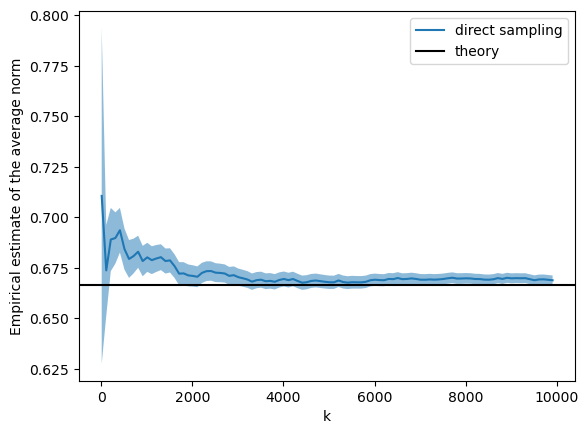

In [5]:
d = 2
n = 20000

points = direct_sampling(d, n)

ks = np.arange(start=10, stop=10000, step=100)
stats = [ direct_sampling_empirical_estimator_norm(points[0:k]) for k in ks]
emp_avg = np.take(stats, 0, axis=1)
emp_err = np.take(stats, 1, axis=1)

plt.plot(ks, emp_avg, label = "direct sampling")
plt.fill_between(ks, emp_avg - emp_err, emp_avg + emp_err, alpha = 0.5)
plt.axhline(y = theoretical_avg(d), color="black", label = "theory")

plt.legend()
plt.xlabel("k")
plt.ylabel("Empirical estimate of the average norm")

**2.4 (0.5 pt)** 
Reproduce exactly the plot in 2.3 for `d = [3,5,8,20]`. Plot each value of d on a different plot.
You should see something strange happening in the plots as the dimension grows. 

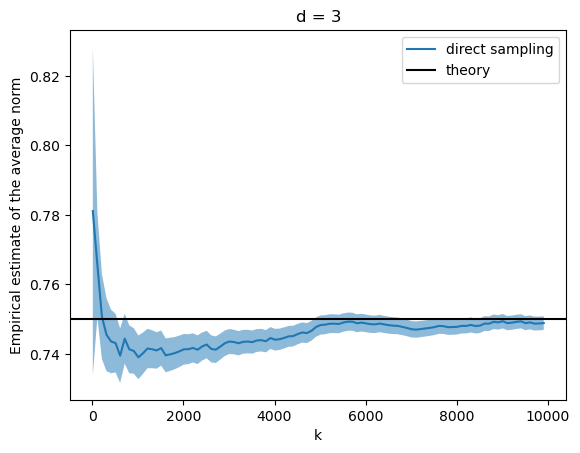

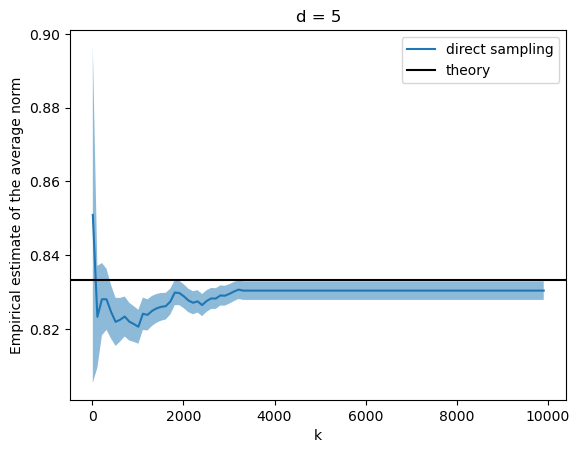

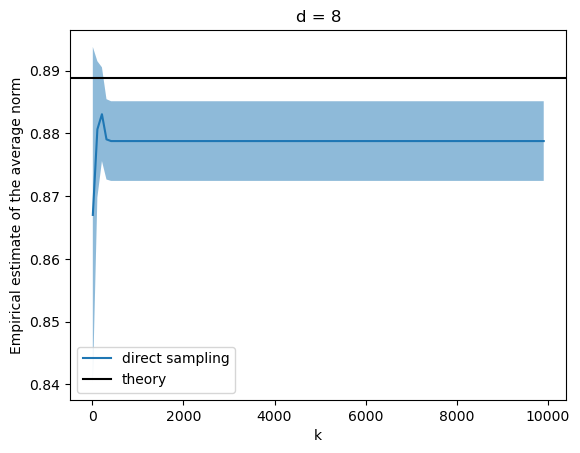

No points sampled for d=20 and n=20000


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


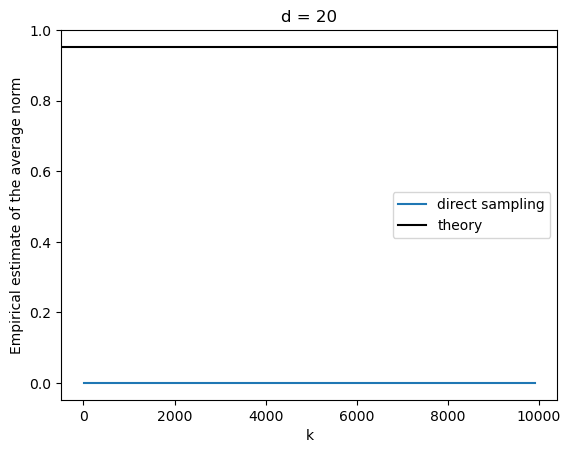

In [6]:
for d in [3,5,8,20]:
    n = 20000

    points = direct_sampling(d, n)

    ks = np.arange(start=10, stop=10000, step=100)
    stats = [ direct_sampling_empirical_estimator_norm(points[0:k]) for k in ks]
    emp_avg = np.take(stats, 0, axis=1)
    emp_err = np.take(stats, 1, axis=1)

    plt.plot(ks, emp_avg, label = "direct sampling")
    plt.fill_between(ks, emp_avg - emp_err, emp_avg + emp_err, alpha = 0.5)
    plt.axhline(y = theoretical_avg(d), color="black", label = "theory")

    plt.legend()
    plt.title(f"d = {d}")
    plt.xlabel("k")
    plt.ylabel("Empirical estimate of the average norm")
    plt.show()

**2.5 (1.5 pt)** Answer the following questions, use max two lines per answer.
1. What unexpected feature appears in the plots as the dimension grows?
2. Why does it appear?
3. What happens at $d=20$?

**Answer**
1. The estimated curve stops changing after a certain value of $k$ which becomes smaller as the dimension grows.
2. When calling `direct_sampling` method with $n$ points, we will get less than $n$ points in general, as we reject some of them. As the dimension increases, we must be rejecting more and more points.
3. At $d=20$, no points are sampled in the disk.

**2.6 (1 pt)** 
Plot the fraction of rejected points in the `direct_sampling` algorithm as a function of `d`, using `d=2, ..., 20`. Fix `n=100000`.

No points sampled for d=16 and n=100000
No points sampled for d=17 and n=100000
No points sampled for d=18 and n=100000
No points sampled for d=19 and n=100000
No points sampled for d=20 and n=100000


Text(0, 0.5, 'fraction rejected points')

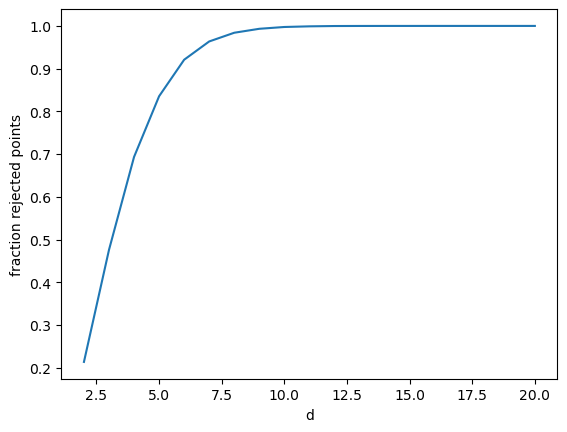

In [8]:
n = 100000
ds = np.arange(2,21)
rejected = [ 1 - len(direct_sampling(d,n))/n for d in ds]
plt.plot(ds, rejected)
plt.xlabel("d")
plt.ylabel("fraction rejected points")

**2.7 (1 pt)**
What happens as $d$ increases? Is our estimation of the norm reliable in high dimension? Answer in max two lines.

**Answer**
When $d$ increases, we start rejecting basically all points we sample in the `discrete_sampling` function. Thus, we have very few, if not zero points with which we can estimate the average norm. Thus in large dimension the estimate is not trustable.

**Comment** 
The effect we are seeing here is often nicknamed "curse of dimensionality". The problem is that the disk $D_d$ occupies a smaller and smaller volume inside the cube $H_d$ as the dimension grows.
For this reason, all points we sample get rejected, as the probability that they will end out of the disk approaches one. 

## Exercise 3: sampling with MCMC in high dimension

In the last exercise, we saw that in high dimensions the curse of dimensionality may hinder the effectiveness of sampling algorithms that work just fine in low dimension. We also learned that "high dimension" can mean as little as $d=15$!
We need to come up with another (smarter) strategy to sample uniformly the disk $D_d$. In the specific case of the disk, one could come up with many smart solutions, but here we will focus on MCMC.

In class, and in Exercise 12, we learned that it is possible to use Markov Chain Monte Carlo (MCMC) to sample from a generic distribution. 
MCMC is first of all a random walk, i.e. a sequence of points $x(t) \in \mathbb{R}^d$ that are generated one after the other with some kind of randomness. 
It is also a Markov Chain, which means that the evolution $x(t) \to x(t+1)$ is random, and that $x(t+1)$ depends only on $x(t)$, and not on all previous positions of the chain.
Finally, through the detailed balance condition, we can design the random evolution $x(t) \to x(t+1)$ such that the stationary distribution of $x(t)$ is the distribution we want.
The detailed balance condition reads
$$
    P(a \to b) \pi(a) = P(b \to a) \pi(b) \quad \forall a,b
$$
where $P(a \to b)$ is the transition probability of going from $a \to b$, $\pi$ is the distribution we want to sample from (the stationary distribution of our MCMC), and $a,b$ are possible states of our random walker (for us, points in $\mathbb{R}^d$).

Let us design an MCMC algorithm to sample from $\pi = $ uniform distribution on the disk, i.e.
$$
    \pi(x) = \begin{cases}
        \frac{1}{\Omega_d} & \text{if } x \in D_d \\
        0 & \text{otherwise}
    \end{cases}
$$
where $\Omega_d$ is the volume of the $d$-dimensional disk $D_d$ (and acts as a normalisation of our p.d.f. $\pi$).
We consider a simple random walker, defined by $x(t=0) = 0 \in \mathbb{R}^d$, and $x(t+1) = x(t) + \Delta$.
$\Delta$ is our evolution step, and is a random variable, independent and identically distributed with p.d.f. $\rho(\Delta)$ at each different time step.
The only freedom we have left in the design of the random walk is the distribution $\rho(\Delta)$, so we need to use the detailed balance condition to fix $\rho$ in order to sample from $\pi$.

**3.1 (1 pt)** Write the detailed balance condition for $a = x$, $b = x + \Delta$, supposing that both $a, b \in D_d$. In other words, we are considering the case in which we propose a step for our random walker, and the step keeps it in the disk. What does it imply for $P(a\to b)$? Answer in 2 lines.

**Answer** 
$$
    P(x \to x + \Delta) \pi(x) = P(x + \Delta \to x) \pi(x+\Delta) 
    \implies
    P(x \to x + \Delta) = P(x + \Delta \to x) \quad \forall x \in S_d, x+\Delta \in S_d
$$
The transition probability between two points inside the disk must be symmetric.

**3.2 (1pt)** Write the detailed balance condition for $a = x$, $b = x + \Delta$, supposing that both $a \in D_d$, and that $b \notin D_d$. In other words, we are proposing a step for our random walker that would bring it out of the disk. What does it imply for the transition probability? Answer in two lines.

**Answer**
$$
    P(x \to x + \Delta) \pi(x) = P(x + \Delta \to x) \pi(x+\Delta) \implies
    P(x \to x + \Delta) = 0 \quad \forall x \in S_d, x+\Delta \notin S_d
$$
The transition probability to move from inside to outside the disk is zero, so the random walker can never exit the disk.

The two points above give us the following MCMC algorithm, which is guaranteed to sample the uniform distribution on the disk $D_d$ (after possibly some time steps of equilibration).
- Initialize $x(t=0) = 0$
- Generate randomly an increment $\Delta \in \mathbb{R}^d$ using a symmetric p.d.f. $\rho$ (due to point 3.1).
- If $x(t) + \Delta \in D_d$, then set $x(t+1) = x(t)+\Delta$
- If $x(t) + \Delta \notin D_d$, then set $x(t+1) = x(t)$ (due to point 3.2)
- Repeat up to a total time $T$.

**Comment:** notice that one could also use a non-symmetric $\rho$, but a symmetric $\rho$ is a simple way of implementing the symmetry of the transition probability.

In what follows, we set $\rho$ to be the uniform distribution in the interval $[-c, c]^d$.

**3.3 (2 pt)** Write a function that implements the MCMC algorithm. It takes as input $d, T, c$ and returns an array of the positions $x(t)$ in the same format as the output of `direct_sampling`. Print the output of the function for $d=2$, $T=5$ and $c=1$.

In [9]:
def mcmc(d, T, c):
    init = np.zeros(d)
    points = [init]
    for t in range(1,T):
        Delta = c * np.random.uniform(low=-1, high=1, size=d)
        candidate = points[-1] + Delta
        if np.linalg.norm(candidate) <= 1:
            points = np.vstack((points, candidate))
        else:
            points = np.vstack((points, points[-1]))

    return points

print(mcmc(2, 5, 0.5))

[[ 0.          0.        ]
 [ 0.42920179 -0.1874887 ]
 [ 0.91035326  0.23289085]
 [ 0.91035326  0.23289085]
 [ 0.91035326  0.23289085]]


**3.4 (1 pt)** Write a function that computes the empirical average of the norm $||x||$ on the output of the function `mcmc`. Print its output on a dataset produced with `mcmc` and $d=2$, $T=5000$, $c=0.2$. Print also the corresponding theoretical value.

In [11]:
def mcmc_empirical_avg(points):
    return np.mean(np.linalg.norm(points, axis=1))

print(mcmc_empirical_avg(mcmc(2,5000,0.2)))
print(theoretical_avg(2))

0.6718223228433904
0.6666666666666666


**3.5 (1 pt)** 
Generate a dataset using `mcmc` with $d=2$, $T=10000$ and $c=0.5$.
For `k in np.arange(start=10, stop=10000, step=100)`, compute the empirical estimator for the norm using the first `k` points of the dataset.
Plot the value of the empirical estimator as a function of `k`.
Add an horizontal line with the theoretical value.

Text(0, 0.5, 'Empirical estimate of the average norm')

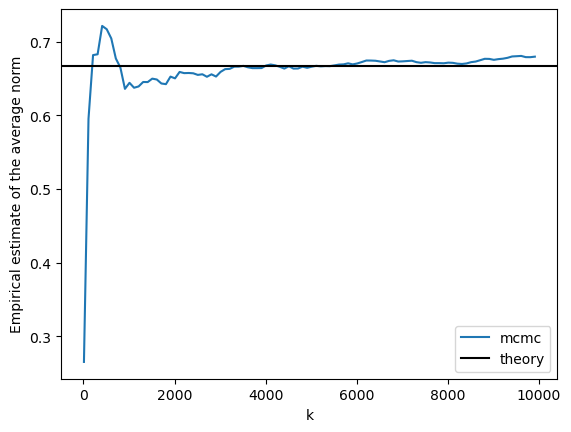

In [12]:
d = 2
T = 10000
c = 0.2

points = mcmc(d, T, c)

ks = np.arange(start=10, stop=10000, step=100)
emp_avg = [ mcmc_empirical_avg(points[0:k]) for k in ks]

plt.plot(ks, emp_avg, label = "mcmc")
plt.axhline(y = theoretical_avg(d), color="black", label = "theory")

plt.legend()
plt.xlabel("k")
plt.ylabel("Empirical estimate of the average norm")

**3.6 (1 pt)** Answer the following questions in one line per question.
1. Compute the expected square distance $||x(t+1)-x(t)||^2$, i.e. the square of how far the walker moves at each step.
2. How should we set $c$ in order to have expected square distance $||x(t+1)-x(t)||^2 = 1/2$? 


**Answer**
1. $\mathbb{E}||x(t+1)-x(t)||^2 = \mathbb{E}||\Delta||^2 = \mathbb{E}\sum_{i=1}^d \Delta_i^2 = d c^2 / 3$.
2. We want $\mathbb{E}||x(t+1)-x(t)||^2 = 1/2$, so we need to have $c = \sqrt{3/(2d)}$.

**Comment** We see that in order to have displacements that are of constant size, i.e. of length that is not growing with $d$, we need to rescale $c$ with a precise function of the dimension $d$ (the constant factor is unimportant, as it does not depend on the dimension). If we do not do that, we risk talking too large steps when the dimension increases. The concept of _scaling_ is ubiquitous when considering systems whose dimensionality can change.

**3.7 (0.5 pt)** 
Reproduce exactly the plot in 3.5 for `d = [3,5,10,15,20,100]`. Plot each value of d on a different plot. Use $T = 10000$ and $c = 0.5 / \sqrt{d}$ (in order to have steps of length that is not scaling with $d$, see 3.6).

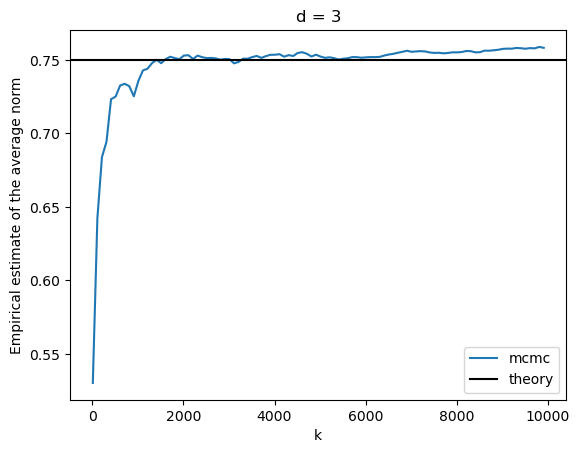

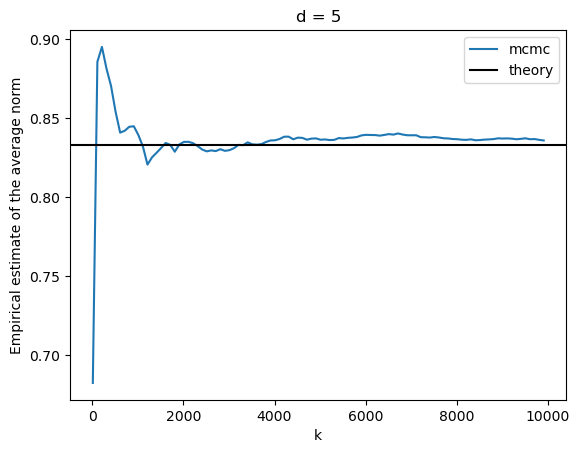

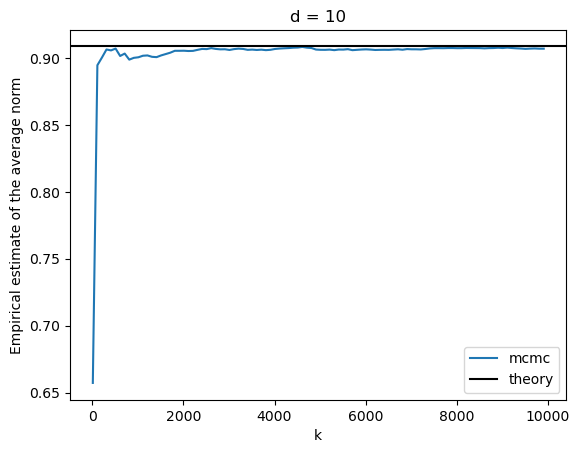

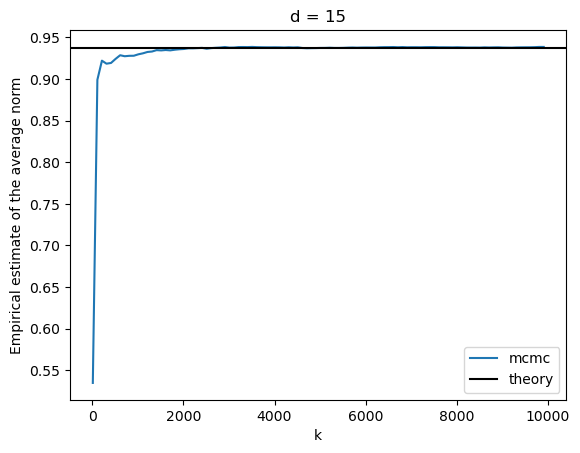

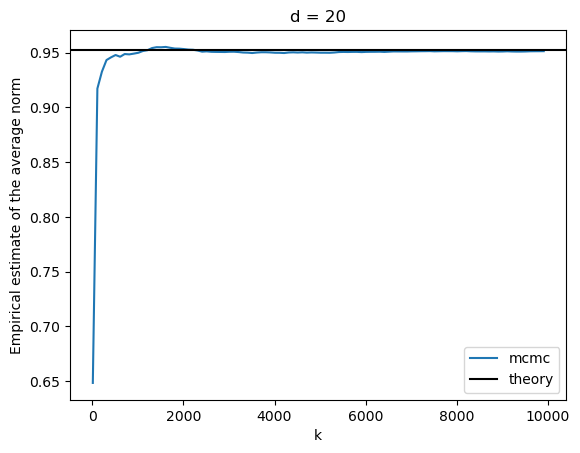

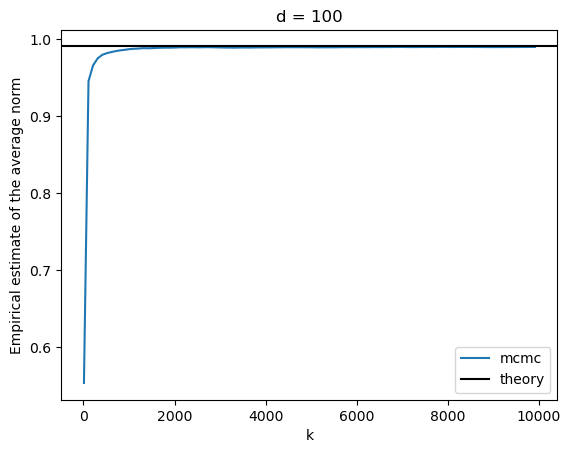

In [13]:
for d in [3,5,10,15,20,100]:
    T = 10000
    c = 0.5 / np.sqrt(d)

    points = mcmc(d, T, c)

    ks = np.arange(start=10, stop=10000, step=100)
    emp_avg = [ mcmc_empirical_avg(points[0:k]) for k in ks]

    plt.plot(ks, emp_avg, label = "mcmc")
    plt.axhline(y = theoretical_avg(d), color="black", label = "theory")

    plt.title(f"d = {d}")
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("Empirical estimate of the average norm")

    plt.show()

**3.8 (2 pt)** Answer the following questions, using max two lines per answer.
1. What is the main difference between the plots for MCMC and the corresponding plots for direct sampling?
2. Why is the convergence speed of the mcmc algorithm mostly independent on the dimension? Compare with direct sampling.

**Answer**
1. The plots for MCMC show that MCMC's performance does not degrade as the dimension $d$ increases. 
2. Because with MCMC all points we sample are inside the disk by construction, while for direct sampling the number of points inside the disk was decreasing rapidly as a function of the dimension.

Actually, as $d$ increases the convergence speed of MCMC seems to improve.
This is due to the fact that the distribution of the length of a random uniform vector in the disk becomes more and more peaked around its mean as $d$ increases (in other words, the variance goes to zero). 

## Exercise 4: error on the mcmc empirical estimator, and the dependence of the average norm on the dimension

**4.1 (2 pt)**
Write a function that estimates the average of the norm and its error. 
It takes as input $d$, $T$, $c$ and another parameter that you may need, and returns a list with two elements, the empirical average and its error.
Print your estimate for the average norm and its error using $d=20$, $T=5000$ and $c = 0.5 / \sqrt{d}$.
Print also the theoretical value.

Hint: revise Exercise 12.

In [14]:
def mcmc_empirical_avg_error(d, T, c, k=20):
    estimates = []
    for i in range(k):
        points = mcmc(d,T,c)
        emp_avg = mcmc_empirical_avg(points)
        estimates = np.append(estimates, emp_avg)

    avg = np.mean(estimates)
    error = np.std(estimates, ddof = 1) / np.sqrt(k)

    return [avg, error]

d = 20
T = 5000
c = 0.5 / np.sqrt(d)
print(mcmc_empirical_avg_error(d, T, c))
print(theoretical_avg(d))

[0.9514686174458333, 0.00036159455539753706]
0.9523809523809523


**4.2 (2pt)** Plot for `d in np.arange(2,20,2)` 
$$
    \frac{1 - \text{Estimate of average norm}(d)}{1 - \text{theoretical value of average norm}(d)}
$$
using $T=5000$ and $c = 0.5 / \sqrt{d}$. 
Add two kinds of error bars:
- one with your estimate of the error
- one with 2 times your estimate of the error. 

Plot an horizontal line at $y = 1$.

_This cell may take a bit more time to run. We suggest that you start coding it with a smaller value of $T$, or a smaller vector of values of $d$, and once you believe that your code works correctly, use the given values._

Text(0, 0.5, '(1 - avg norm)/(1 - theory)')

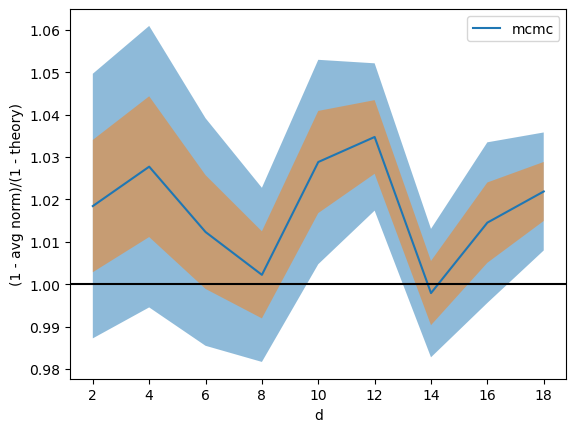

In [15]:
T = 5000
c = 0.5 / np.sqrt(d)

ds = np.arange(2,20,2)

estimates = []
errors = []
for d in ds:
    estimate, error = mcmc_empirical_avg_error(d, T, c) 
    estimate = (1-estimate)/(1-theoretical_avg(d))
    error = error / (1-theoretical_avg(d))
    estimates = np.append(estimates, estimate)
    errors = np.append(errors, error)

plt.plot(ds, estimates, label = "mcmc")
plt.fill_between(ds, estimates - 2*errors, estimates + 2*errors, alpha = 0.5)
plt.fill_between(ds, estimates - errors, estimates + errors, alpha = 0.5)

plt.axhline(y=1, color="black")

plt.legend()
plt.xlabel("d")
plt.ylabel("(1 - avg norm)/(1 - theory)")


**Comment**
We observe that as the dimension grows, the average norm $||x||$ of the points in the unit disk converges to 1. This means that in high dimension, the volume inside the disk is very much concentrated on a thin shell next to the boundary $||x||=1$, while the center of the disk occupies a vanishingly small fraction of the volume. Weird!